# Lung Cancer Subclassification Using FastAI and HuggingFace

#### About This Data:

This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.

There are five classes in the dataset, each with 5,000 images, being:

*   Lung benign tissue
*   Lung adenocarcinoma
*   Lung squamous cell carcinoma
*   Colon benign tissue
*   Colon adenocarcinoma

All images are de-identified, HIPAA compliant, validated, and freely available for download to AI researchers.



*   [Dataset Location](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images)
*   [Original Paper](https://arxiv.org/abs/1912.12142v1)

Citation:
Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019



#Data Wrangling and EDA

We first install libraries not preinstalled on Colab



In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 26.1 MB/s 
     |████████████████████████████████| 163 kB 56.7 MB/s 


Import our libraries



In [3]:
import numpy as np
import torch
import splitfolders
import timm
from fastai.vision.augment import *
from fastai.vision.all import *
from fastai.vision import *
from fastai.vision.learner import vision_learner
from fastai.vision.widgets import *
from fastai.metrics import *
from fastai.interpret import ClassificationInterpretation
from fastai.callback.all import *
from fastai.vision.data import *
from torchvision.models.resnet import resnet18, resnet34, resnet50

Check our GPU instance. This is important as we need a GPU to train our model.

In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'

Now that we're set up, we can move on to wrangling our data.

1.   We first download our data and upload to Google Drive.
2.   We mount our Drive in Colab.
3.  We then remove images of colon tissue, leaving only lung tissue.



We can confirm there are 3 remaining classes in our Drive.

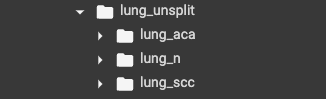

We create a variable for the path to our input folder.

In [3]:
input = '/content/drive/MyDrive/lung_unsplit'

We use "splitfolders" to split into training, validation, and test sets to the named output folder. 70% of our images will become training data, 20% of our images will become validation data, and 10% will be set aside as test data.

In [ ]:
splitfolders.ratio(input, output='/content/drive/MyDrive/lung_split', 
                   seed=42, ratio=(.7,.2,.1), group_prefix=None)

We can confirm our split has taken place as planned.

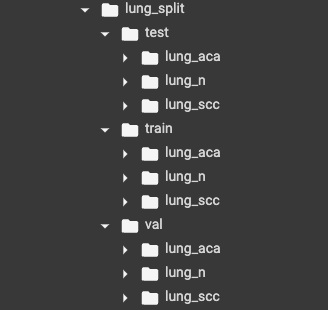


We create a variable for our split dataset.

In [6]:
path = '/content/drive/MyDrive/lung_split'

Let's create variables for our transformations and batch size.



In [7]:
tfms = aug_transforms(do_flip=True, max_rotate=10.0)
bs = 64

Let's create our DataLoaders. We will be resizing these images to 224 x 224 as the CNNs we plan to utilize for transfer learning were trained on 224 x 224 image resolution.

We choose to squish the image, rather than crop or zoom, so no image data is lost.

In [8]:
dls = ImageDataLoaders.from_folder(path, train='train', valid='val', ds_tfms=tfms, 
                                   num_workers = 4, item_tfms=Resize(224, ResizeMethod.Squish), bs=bs)

We can now check our classes.

In [9]:
dls.vocab

['lung_aca', 'lung_n', 'lung_scc']

As expected, our three desired classes are present.

*   Lung adenocarcinoma: 'lung_aca'
*   Lung benign tissue: 'lung_n'
*   Lung squamous cell carcinoma: 'lung_scc'







Let's check the number of images in our train and validation sets.


In [10]:
print(len(dls.train_ds), len(dls.valid_ds))

10500 3000


We started with 15,000 images. 70% to train would be 10,500 images. 20% to validation would be 3,000 images. The remaining 10%, or 1,500 images, are set aside to test our deployed model.

Our classes are also of a similar size, so we can conclude the data is balanced.

Let's view our image data so far. We can accomplish this by showing a batch size that we specify.

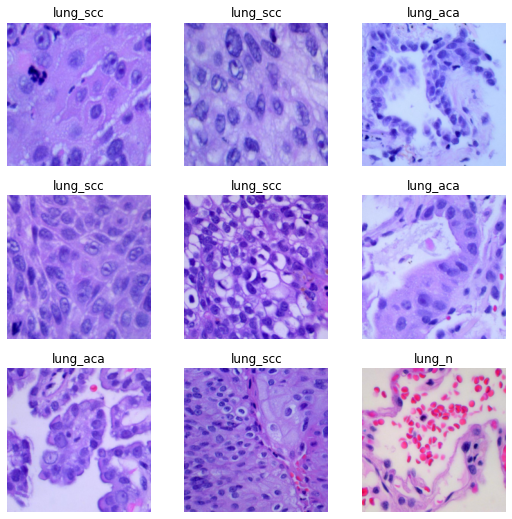

In [11]:
dls.show_batch(max_n=9)

Let's build our model using transfer learning. First, we create our learner.



In [12]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We can use "lr_find" to pick a good learning rate.

SuggestedLRs(valley=0.0005754399462603033)

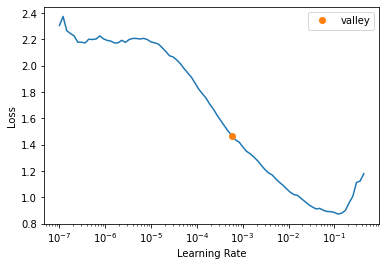

In [13]:
learn.lr_find()

We use "fine_tune" to train a model without starting from scratch. Rather than initialize a model with random weights, we will use a model pre-trained on ImageNet. We will leverage the features this model has already learned and train the last few layers on our particular dataset.

In [14]:
learn.fine_tune(2, 3e-3)

After two epochs, it seems likely our model may start to overfit. We conclude training here.

Let's visualize our loss by plotting it.

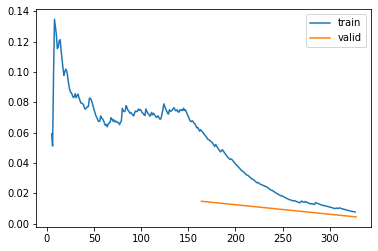

In [15]:
learn.recorder.plot_loss(with_valid=True)

At roughly 300 batches processed, our training and validation loss are at their lowest.

Let's view some predictions.

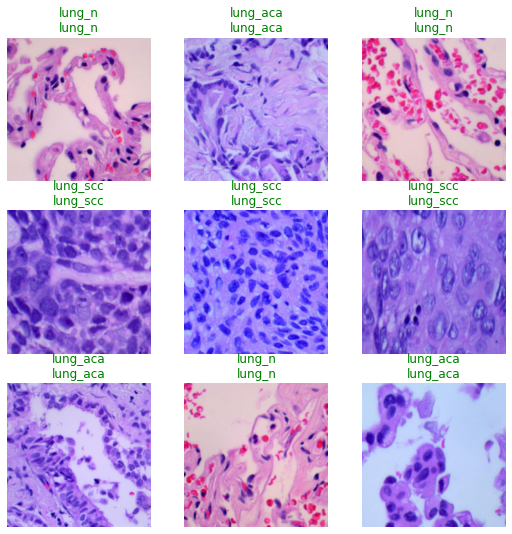

In [16]:
learn.show_results()

We can also make predictions on individual images. Let's try a few from our test set.

In [17]:
learn.predict('/content/drive/MyDrive/lung_split/test/lung_scc/lungscc101.jpeg')

('lung_scc', TensorBase(2), TensorBase([9.3259e-06, 1.3946e-08, 9.9999e-01]))

The predict method returns the decoded prediction (lung_scc here,) the index of the predicted class, and the probabilities of all classes in order of their index labels. In this instance, the model correctly predicted lung squamous cell carcinoma.

The predict method will also take a PIL image. Let's try that. 

In [18]:
im = PILImage.create('/content/drive/MyDrive/lung_split/test/lung_scc/lungscc1000.jpeg')

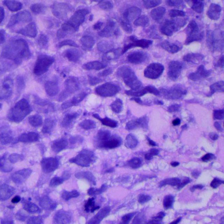

In [19]:
im.thumbnail((224, 224))
im

In [20]:
learn.predict(im)

('lung_scc', TensorBase(2), TensorBase([3.0774e-06, 1.1245e-07, 1.0000e+00]))

Our model correctly predicted lung squamous cell carcinoma using a PIL image.

Let's also interpret our model using a confusion matrix.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

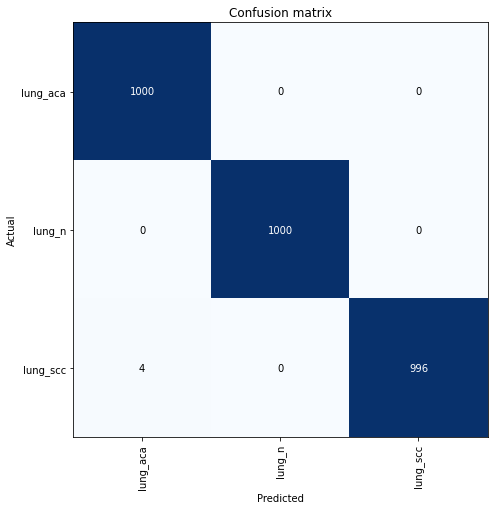

In [22]:
interp.plot_confusion_matrix(figsize=(7,7))

Our model is performing well and has only misclassified cancerous tissue. This is encouraging, as the model should not fail diagnose cancerous tissue or misdiagnose benign tissue.

We can use our interpretation object to see where the model made the worst predictions and where it was least confident.

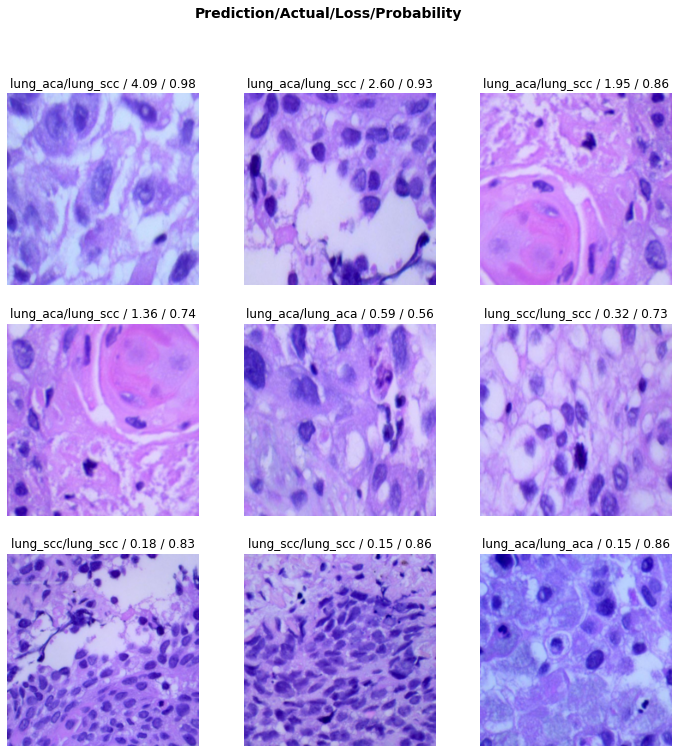

In [23]:
interp.plot_top_losses(9, figsize=(12,12))

Alternatively, we can use "ImageClassifierCleaner" to view the highest-loss images to allow for removal or relabeling.

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Our highest-loss images do not look to be misclassified or labeled incorrectly. We should not make any adjustments.

# Preprocessing and Modeling

Now that we have a good sense of our data and baseline from our resnet50 model, let's try some others models from other families that should be similar to our baseline. We will utilize the same transformations, batch size, and learning rate in an attempt to keep things consisent.

# Model 1: resnet50d Family: Resnetd

Like before we create our learner, passing in the model name as a string as this is coming from TIMM and not the FastAI library.

In [25]:
resnet50d = vision_learner(dls, 'resnet50d', metrics=accuracy)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


We use "fine_tune" to utilize a pre-trained model.

In [26]:
resnet50d.fine_tune(2, 3e-3)

We plot our train and validation loss.

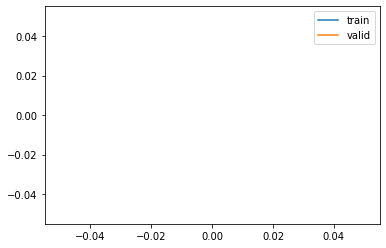

In [53]:
resnet50d.recorder.plot_loss(with_valid=True)

Finally, we create a confusion matrix to interpret our model.

In [33]:
interp_resnet50d = ClassificationInterpretation.from_learner(resnet50d)

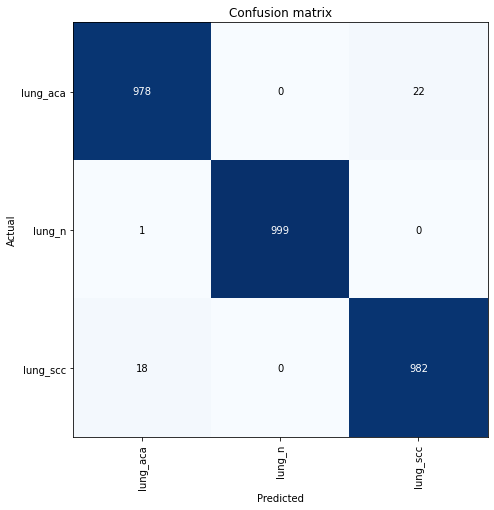

In [34]:
interp_resnet50d.plot_confusion_matrix(figsize=(7,7))

# Model 2: efficientnetv2_rw_t Family: Efficientnetv2

Like before we create our learner, passing in the model name as a string as this is coming from TIMM and not the FastAI library.

In [35]:
efficientv2 = vision_learner(dls, 'efficientnetv2_rw_t', metrics=accuracy)

We use "fine_tune" to utilize a pre-trained model.

In [36]:
efficientv2.fine_tune(2, 3e-3)

We plot our train and validation loss.

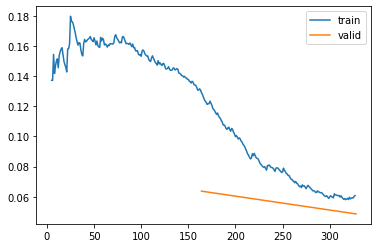

In [37]:
efficientv2.recorder.plot_loss(with_valid=True)

Finally, we create a confusion matrix to interpret our model.

In [38]:
interp_efficientv2 = ClassificationInterpretation.from_learner(efficientv2)

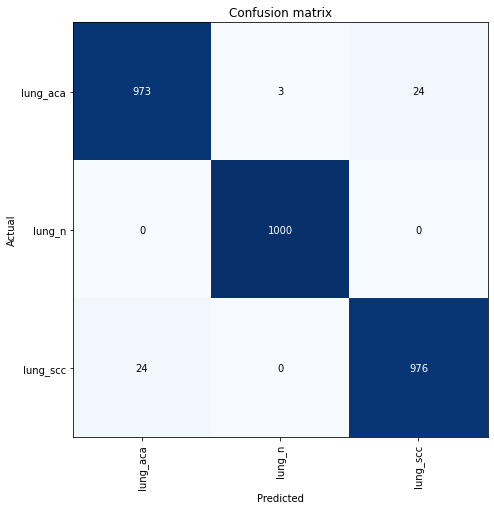

In [39]:
interp_efficientv2.plot_confusion_matrix(figsize=(7,7))

# Model 3: regnetz_b16 Family: Regnetz

Like before we create our learner, passing in the model name as a string as this is coming from TIMM and not the FastAI library.

In [40]:
regnetz16 = vision_learner(dls, 'regnetz_b16', metrics=accuracy)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/regnetz_b_raa-677d9606.pth" to /root/.cache/torch/hub/checkpoints/regnetz_b_raa-677d9606.pth


We use "fine_tune" to utilize a pre-trained model.

In [41]:
regnetz16.fine_tune(2, 3e-3)

We plot our train and validation loss.

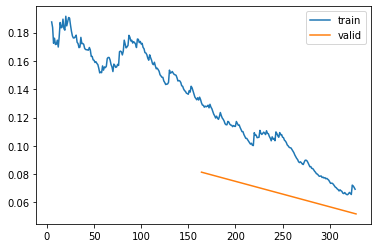

In [42]:
regnetz16.recorder.plot_loss(with_valid=True)

Finally, we create a confusion matrix to interpret our model.

In [43]:
interp_regnetz16 = ClassificationInterpretation.from_learner(regnetz16)

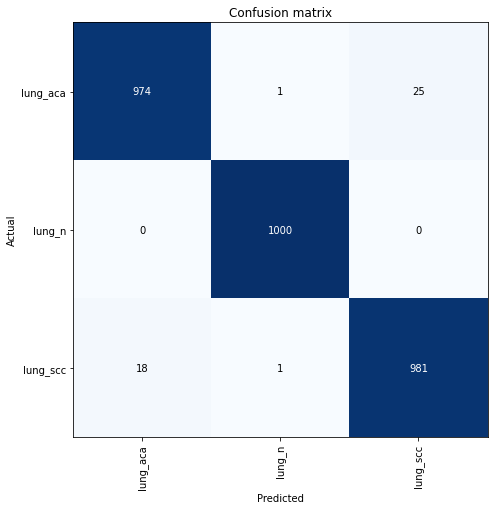

In [44]:
interp_regnetz16.plot_confusion_matrix(figsize=(7,7))

# Choosing Our Model

Interestingly, our original resnet50 model performed the best. Other models were less accurate and didn't classify as well.

Satisfied with our model, we can export it for deployment.

In [45]:
learn.export('lung.pkl')

# Deploying Our Model

We will be deploying our model with Hugging Face Spaces. A Space is a special kind of repository that hosts application code for Machine Learning demos. These applications can be written using Python libraries (SDKs) like Streamlit or Gradio. 

In our case, we choose Gradio due to its simplicity and flexibility. Gradio is specifically built with machine learning models in mind. If one wants to create a UI specifically for a machine learning model, Gradio's simple setup and execution streamlines the process. Additionally, Gradio allows the user to grab an API so one can use it as a jumping-off point to build a full fledged app.

We must first install and import the necessary Gradio library.

In [46]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.1 MB/s 
     |████████████████████████████████| 272 kB 70.7 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 106 kB 72.4 MB/s 
     |████████████████████████████████| 2.3 MB 59.0 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 212 kB 70.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 80 kB 9.3 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 4.0 MB 52.0 MB/s 
     |████████████████████████████████| 593 kB 64

In [47]:
import gradio as gr

We will first set up our Space on Hugging Face. We choose the Apache license and Gradio for our SDK as previously mentioned. We'll also set this to "public."

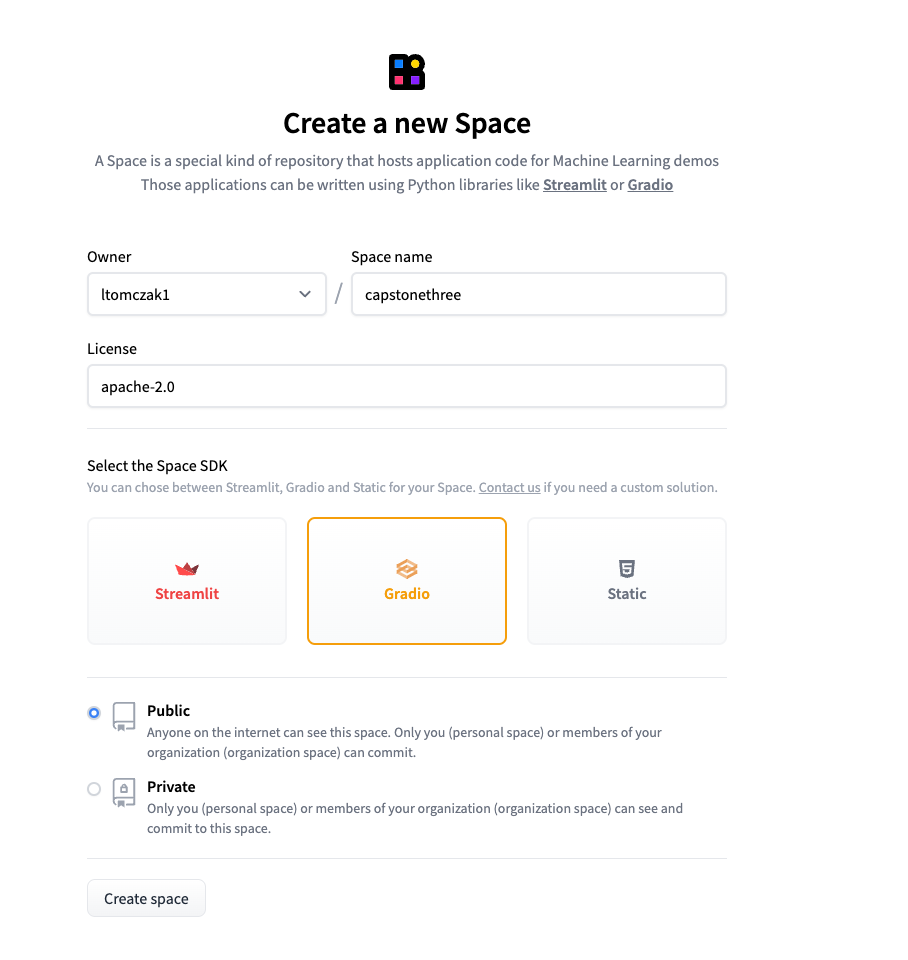

We then load our saved model.

In [54]:
learn = load_learner('/content/drive/MyDrive/lung_split/lung.pkl')

We begin creating the Gradio interface by defining our categories by the order they are indexed.

In [55]:
categories = ('ACA', 'Benign', 'SCC')

We must also provide a function Gradio can call. In this case we will return the decoded prediction, the index of the predicted class, and the probabilities of all classes in order of their index labels (as we saw previously.) We return a dictionary of the possible categories and the probability of each one.


In [56]:
def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

Now we create the actual interface. We pass in our function from above, our input (an image,) labels as output, and examples (images we will push to Hugging Face.)

In [57]:
image = gr.inputs.Image(shape=(768, 768))
label = gr.outputs.Label()
examples = ['/content/drive/MyDrive/lung/test/lung_aca/lungaca1000.jpeg', '/content/drive/MyDrive/lung/test/lung_n/lungn1000.jpeg', '/content/drive/MyDrive/lung/test/lung_scc/lungscc1000.jpeg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

We can try launching. This would typically run locally, but Gradio provides a link when executing in Colab.

In [58]:
intf.launch(inline=False)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://522cc059cc272549.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f815ef5dcd0>,
 'http://127.0.0.1:7861/',
 'https://522cc059cc272549.gradio.app')

We click the provided link and see our app is functional!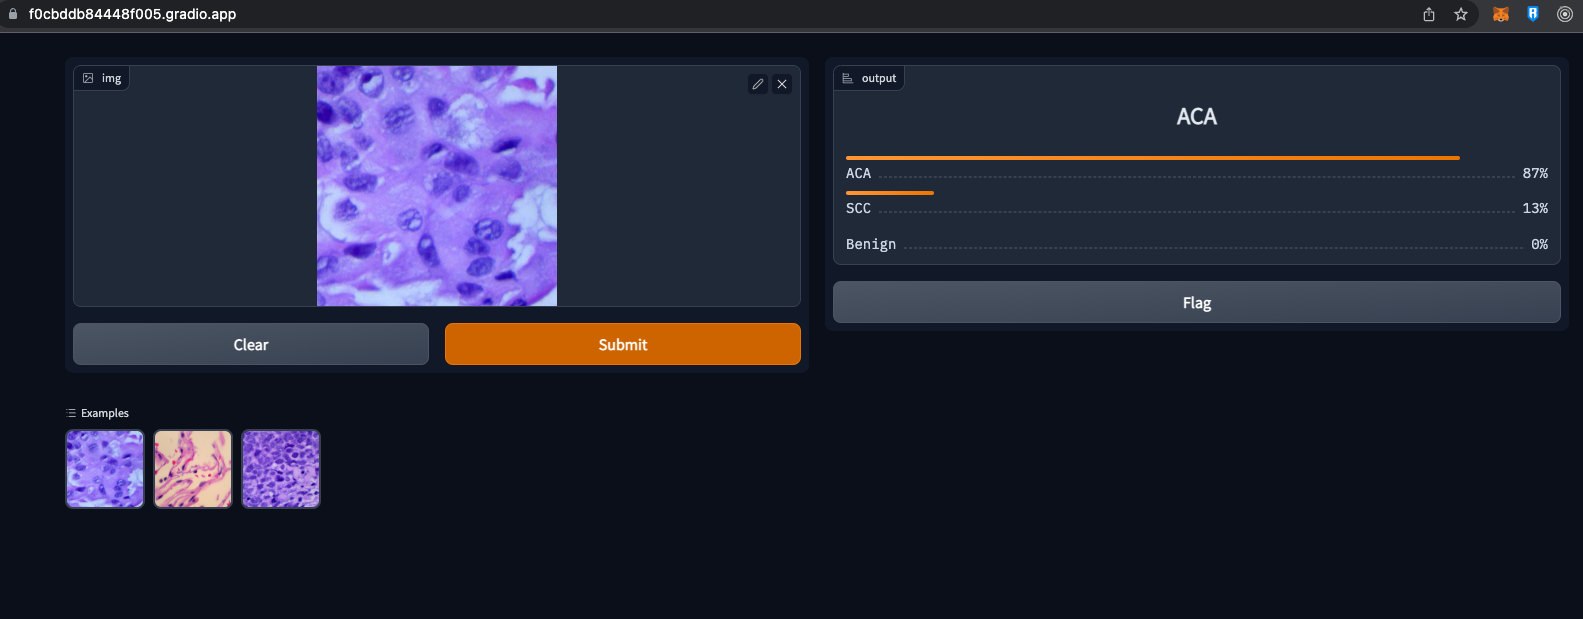

Gradio requires a python script, so we will alter this code slightly and push the script, model, examples, and requirements file to Gradio.

# Our model is deployed! 

*   [The app can be accessed here.](https://huggingface.co/spaces/ltomczak1/capstonethree)
*   [Drag and drop images from the publicly available test set here.](https://drive.google.com/drive/folders/1Udf0UIwb4qSeBcejveGllrDWE9wNWvfK?usp=sharing)
*   Or, feel free to play with the examples provided.





## Note: I wanted to try some more models and also try resnet50 that was not pretrained, but Colab currently limiting my compute units on their free GPU. This is the most I could get through so far without upgrading.